## Prediction

Suppose a hockey team is playing in a best-of-seven championship. They lost the first 2 games 0-1 and 2-3 then won the next two games 8-1 and 4-0. What is the probability that they win the next game and what is their probability of winning the championship?

We make several assumptions:

* Goal scoring is approx a Poisson process, equally likely for a goal to be scored at any point during a game
* Against a given opponent, team has a long term average goals per game (donated by lambda)

Strategy:
1. Use previous statistics from old games to choose prior for lambda
2. Use score from first 4 games to estimate lambda for the 2 teams
3. Use the posterior distributions of lambda to compute distribution of goals for each team, distribution of goal differential and probability that each team wins the next game.
4. Compute probability that each team wins the championship.

Using the data given, our prior is a gaussian with mean 2.8 and std dev 0.3.

We can approximate with a discrete Pmf for now.



In [26]:
import numpy as np
import scipy
import thinkbayes
import math

def MakeGaussianPmf(mu, sigma, num_sigmas, n=101):
    pmf = thinkbayes.Pmf()
    low = mu - num_sigmas*sigma
    high = mu + num_sigmas*sigma
    
    ## num sigmas is the number of sigmas to span above and below the mean
    
    for x in np.linspace(low, high, n):
        p = scipy.stats.norm.pdf(mu, sigma, x)
        pmf.Set(x, p)
        
    pmf.Normalize()
    return pmf

gpmf = MakeGaussianPmf(2.8, 0.3, 4)

In [48]:

def EvalPoissonPmf(lam, k):
    return (lam)**k * math.exp(-lam) / math.factorial(k)

def EvalExponentialPdf(lam, x):
    return lam * math.exp(-lam * x)

class Hockey(thinkbayes.Suite):
    
    def __init__(self, name=''):
        pmf = thinkbayes.MakeGaussianPmf(2.7, 0.3, 4)
        thinkbayes.Suite.__init__(self, pmf)
        self.name = name
        
    def Likelihood(self, data, hypo):
        lam = hypo
        k = data
        like = EvalPoissonPmf(lam, k)
        return like
    
    
suite1 = Hockey('bruins')
suite1.UpdateSet([0, 2, 8, 4])

suite2 = Hockey('canucks')
suite2.UpdateSet([1, 3, 1, 0])





0.0005725202359080636

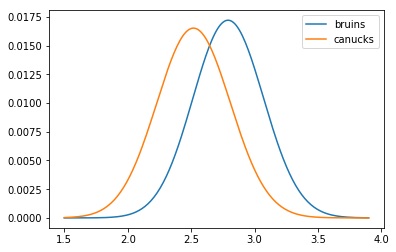

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline



suites = [suite1, suite2]

for suite in suites:
    values = []
    probs = []
    for value, prob in suite.Items():
        values.append(value)
        probs.append(prob)

    plt.plot(values, probs, label=suite.name)
plt.legend()
plt.show()

## Poisson processess

A **process** is a stochastic model of a physical system (stochastic means it's not deterministic, there're randomness in it).

A Bernoulli process is a model of a sequence of events (trials) where there are 2 possible outcomes, it's a good model for a series of coin tosses or series of shots on goal.

A Poisson process is a continuous version of a Bournoulli process. Events can happen at any point in time with equal probability. Good model for goals scored in a hockey game (as an approximation).

Makes the computation of distribution of goals per game more efficient. 

If we know our value of lamba, computation of the distribution of goals per game is very straightfoward (using the Poisson distribution).

The likelihood of a team scoring *k* goals given a lambda value can be computed across different hypotheses (lambdas). We can update our posterior with the likelihood function, using the observed number of goals in previous games (data).

However, if we have distributions for the probable values of lamba, then we need to get a mixture of Poisson distributions (of goals scored) for each possible lambda value.

This mixture weights the different Poisson distributions based on the probabilities in the distribution of lambda.

The probability of winning can be found by calculating the goal distributions for both teams and then taking the distribution for the goal differential. We can then work out how likely it is that one team has more goals than the other. We can also get the probability of it being a draw.

If games are a draw, they go to sudden death. This is where the first team to score wins. We can then calculate the distribution for the amount of time require for each team to score and then get the distribution for team A scoring before team B.

The probability of winning is the probability of team A winning outright plus the prob of a draw times the prob of winning sudden death.

To see the prob of winning the series we add the prob of them winning the next two games or splitting the next two (win one, lose one) and winning the third.


In [70]:
def MakeMixture(metapmf, name='mix'):
    mix = Pmf(name=name)
    for pmf, p1 in metapmf.Items():
        for x, p2 in pmf.Items():
            mix.Incr(x, p1 * p2)
    return mix


def MakePoissonPmf(lam, high):
    pmf = Pmf()
    for k in range(0, high+1):
        p = EvalPoissonPmf(lam, k)
        pmf.Set(k, p)
    pmf.Normalize()
    return pmf

def MakeGoalPmf(suite):
    metapmf = thinkbayes.Pmf()
    
    for lam, prob in suite.Items():
        pmf = MakePoissonPmf(lam, 10)
        metapmf.Set(pmf, prob)
        
    mix = MakeMixture(metapmf)
    return mix

goal_dist1 = MakeGoalPmf(suite1)
goal_dist2 = MakeGoalPmf(suite2)
diff = goal_dist1 - goal_dist2

p_win = diff.ProbGreater(0)
p_loss = diff.ProbLess(0)
p_tie = diff.Prob(0)

print(p_win, p_loss, p_tie)

def MakeGoalTimePmf(suite):
    metapmf = thinkbayes.Pmf()
    
    for lam, prob in suite.Items():
        pmf = thinkbayes.MakeExponentialPmf(lam, high=2, n=2001)
        metapmf.Set(pmf, prob)
        
    mix = thinkbayes.MakeMixture(metapmf)
    return mix

time_dist1 = MakeGoalTimePmf(suite1)
time_dist2 = MakeGoalTimePmf(suite2)

p_overtime = thinkbayes.PmfProbLess(time_dist1, time_dist2)

print(p_overtime)

p_win = diff.ProbGreater(0) + diff.Prob(0) * p_overtime
print(p_win)

p_series = p_win**2

p_series += 2 * p_win * (1-p_win) * p_win
print(p_series)

0.45844446316038223 0.36692759551847764 0.1746279413211394
0.5241042376724285
0.5499677072228035
0.5747020449130835


Improving model:

* Better prior, not averaging across all teams.
* More data, use a greater number of match ups. Can weight more recent games higher.

Note that changing the prior to use a higher-variance prior (based on data from regular season) changes the odds of team winning from 57% to 80%. Minimal data, so very sensitive to prior!
